In [96]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.signal import find_peaks

In [84]:
class RFAData:
    def __init__(self, filename):
        """Initialize RFA data from a measurement file."""
        # Header information
        self.measurement_date = None
        self.operator = ""
        self.comments = ""
        self.projectile = ""
        
        # Beam parameters
        self.energy = 0.0
        self.extractor = 0.0
        self.focus1 = 0.0
        self.focus2 = 0.0
        
        # RFA parameters
        self.suppressor_voltage = 0.0
        self.rfa_comments = ""
        self.ret_config = ""
        self.supp_config = ""
        
        # Wien filter
        self.wien_voltage = 0.0
        
        # Sweep parameters
        self.sweep_start = 0.0
        self.sweep_end = 0.0
        self.sweep_step = 0.0
        self.measurement_time = 0.0
        self.integration_time = 0.0
        self.plc = 0.0
        self.points_per_step = 0.0
        
        # Measurement data
        self.retarding_voltage = None  # Will be numpy array
        self.current = None       # Will be numpy array
        
        self._load_file(filename)
        self._read_configuration()
        self._remove_first_point()
    
    def _load_file(self, filename):
        """Load and parse the measurement file."""
        # print(f"loading file: {filename}")
        with open(filename, 'r') as file:
            lines = file.readlines()
            
        # Parse header information
        data_start_index = None
        in_rfa_section = False  # Flag to track if we're in the RFA section


        # first, record date (that doesn't fit the standard ":" format):
        datetime_str = lines[0].strip().replace("Measured on ", "")
        self.measurement_date = datetime.strptime(datetime_str, "%H:%M:%S %d/%m/%Y")
        
        for i, line in enumerate(lines):
            line = line.strip()
            
            if not line:
                continue
            
            # Check for data section
            if "Retading voltage (kV)" in line and "Mean current FC (A)" in line:
                data_start_index = i + 1
                break
                
            # Check if we're entering RFA section
            if "RFA#:" in line:
                in_rfa_section = True
                
            # Handle fields that might be empty
            if ":" in line:
                parts = line.split(':', 1)  # Split on first colon only
                field = parts[0].strip()
                value = parts[1].strip() if len(parts) > 1 else ""
                
                # Remove any remaining tabs
                value = value.replace('\t', '').strip()
                    
                if field == "Operated by":
                    self.operator = value
                elif field == "Comments":
                    # Assign to appropriate comments field based on section
                    if in_rfa_section:
                        self.rfa_comments = value
                    else:
                        self.comments = value
                elif field == "Projectile":
                    self.projectile = value
                elif field == "Energy (V)":
                    self.energy = float(value)/1000 if value else 0.0 # also convert to kV
                elif field == "Extractor (%)":
                    self.extractor = float(value) if value else 0.0
                elif field == "Focus 1 (%)":
                    self.focus1 = float(value) if value else 0.0
                elif field == "Focus 2 (%)":
                    self.focus2 = float(value) if value else 0.0
                elif field == "Suppressor voltage (V)":
                    self.suppressor_voltage = float(value) if value else 0.0
                elif field == "Wien voltage (V)":
                    self.wien_voltage = float(value) if value else 0.0
                elif field == "Sweep start (kV)":
                    self.sweep_start = float(value) if value else 0.0
                    # set if peak or whole
                    if self.sweep_start <= 0.1:
                        self.is_peak = False
                    else:
                        self.is_peak = True
                elif field == "Sweep end (kV)":
                    self.sweep_end = float(value) if value else 0.0
                elif field == "Sweep step (V)":
                    self.sweep_step = float(value)/1000 if value else 0.0 # also convert to kV
                elif field == "Measurement time (s)":
                    self.measurement_time = float(value) if value else 0.0
                elif field == "Integration time (s)":
                    self.integration_time = float(value) if value else 0.0
                elif field == "PLC":
                    self.plc = float(value) if value else 0.0
                elif field == "Points per step":
                    self.points_per_step = float(value) if value else 0.0
        
        if data_start_index is None:
            raise ValueError("Could not find data section in file")
            
        # Parse measurement data
        data_lines = [line.strip() for line in lines[data_start_index:] if line.strip()]
        voltage_data = []
        current_data = []
        
        for line in data_lines:
            v, i = line.split('\t')
            voltage_data.append(float(v.replace('E', 'e')))
            current_data.append(float(i.replace('E', 'e')))
        
        self.retarding_voltage = np.array(voltage_data)
        self.current = np.array(current_data)

    def _read_configuration(self):
            """Set RFA configuration based on measurement date"""
            date_configs = {
                "2024-11-27": (1, "2grid", "1grid"),
                "2024-11-29": (2, "2grid", "d_small"),
                "2024-12-04": (3, "1grid", "1grid"),
                "2024-12-06": (4, "1grid", "d_big")
            }
            
            date_str = self.measurement_date.strftime(r"%Y-%m-%d")
            if date_str in date_configs:
                self.measurement_day, self.ret_config, self.supp_config = date_configs[date_str]

    def _remove_first_point(self):
        """Remove first point from measurement data arrays, as that is most often erroneous."""
        if len(self.retarding_voltage) > 0 and len(self.current) > 0:
            self.retarding_voltage = self.retarding_voltage[1:]
            self.current = self.current[1:]
    
    def __repr__(self):
        return (f"RFAData: \n"
                f"\tretarding configuration = {self.ret_config}, \n"
                f"\tsuppressor configuration = {self.supp_config}, \n"
                f"\tbeam energy = {self.energy} kV, \n"
                f"\tsweep starting voltage = {self.sweep_start} kV, \n"
                f"\tsuppressor voltage = {self.suppressor_voltage}")

In [85]:
all_rfa_datas = []

# Loop through the raw data folder and its subfolders
for root, dirs, files in os.walk(r"raw data"):
    for file in files:
        if file.endswith(".txt") and not ("wein" in str(file) or "wien" in str(file)):
            file_path = os.path.join(root, file)
            all_rfa_datas.append(RFAData(file_path))

# Print the loaded data
for rfa in all_rfa_datas[:2]:
    print(rfa)

RFAData: 
	retarding configuration = 2grid, 
	suppressor configuration = 1grid, 
	beam energy = 4.0 kV, 
	sweep starting voltage = 0.0 kV, 
	suppressor voltage = -100.0
RFAData: 
	retarding configuration = 2grid, 
	suppressor configuration = 1grid, 
	beam energy = 4.0 kV, 
	sweep starting voltage = 0.0 kV, 
	suppressor voltage = 0.0


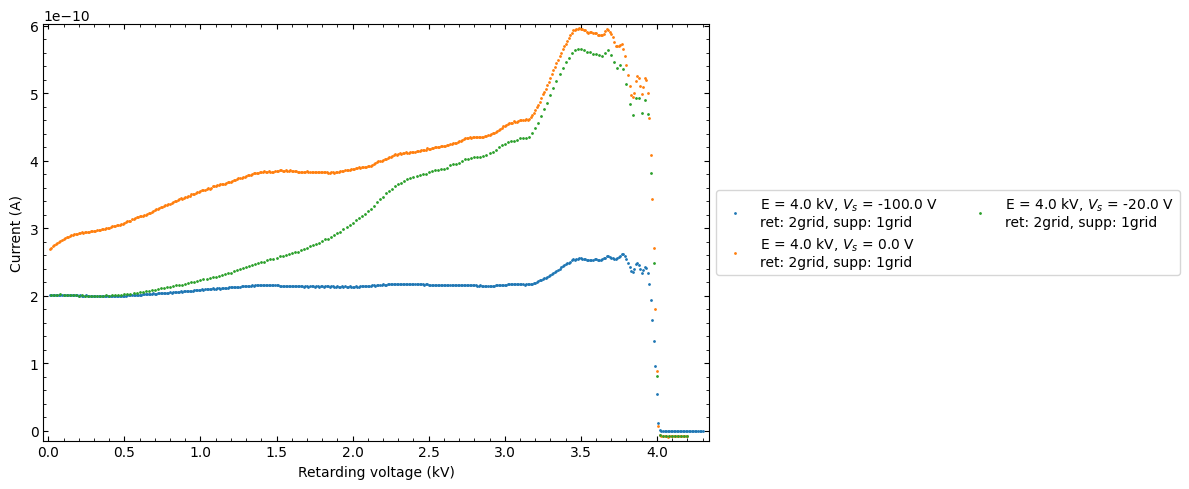

In [86]:
def basic_plot(rfa_datas, show=True):
    """Plot the mean current vs retarding voltage for the given RFA data.
        Either shows or returns (fig, ax)."""
    fig, ax = plt.subplots(figsize=(12, 5), tight_layout=True)
    
    for data in rfa_datas:
        ax.plot(data.retarding_voltage, data.current, 
                label=f"E = {data.energy} kV, $V_s$ = {data.suppressor_voltage} V \nret: {data.ret_config}, supp: {data.supp_config}",
                marker='o', linestyle='', markersize=1)
    
    ax.set_xlabel("Retarding voltage (kV)")
    ax.set_ylabel("Current (A)")

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    ax.margins(x=0.01, y=0.01)

    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax.minorticks_on()
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    
    if show:
        plt.show()
    else:
        return fig, ax

basic_plot(all_rfa_datas[:3])

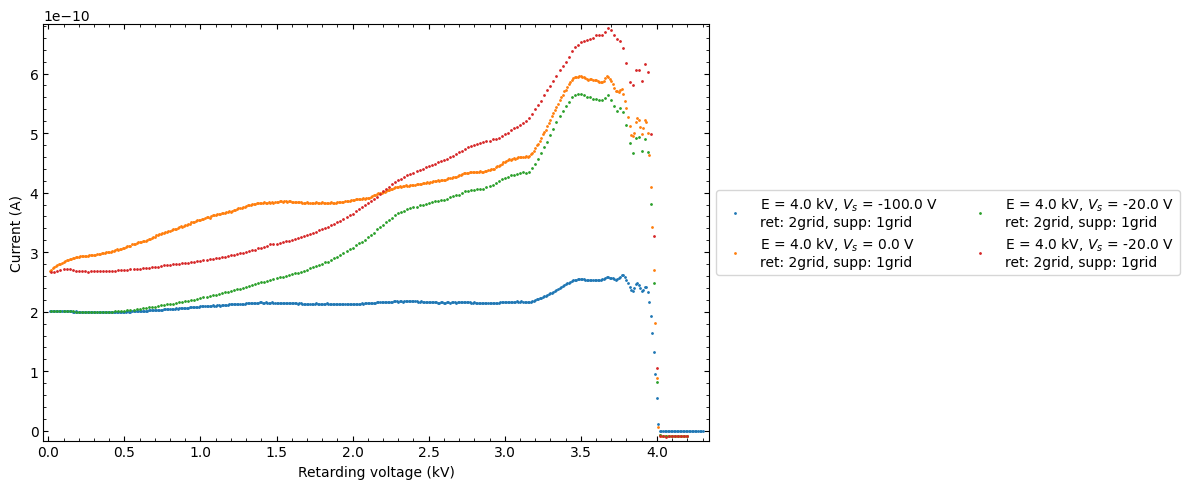

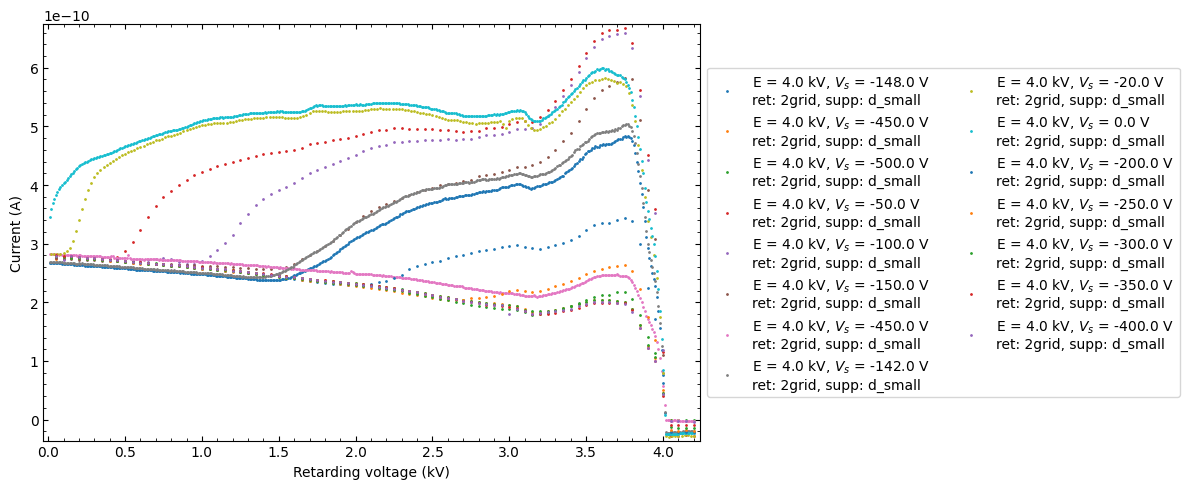

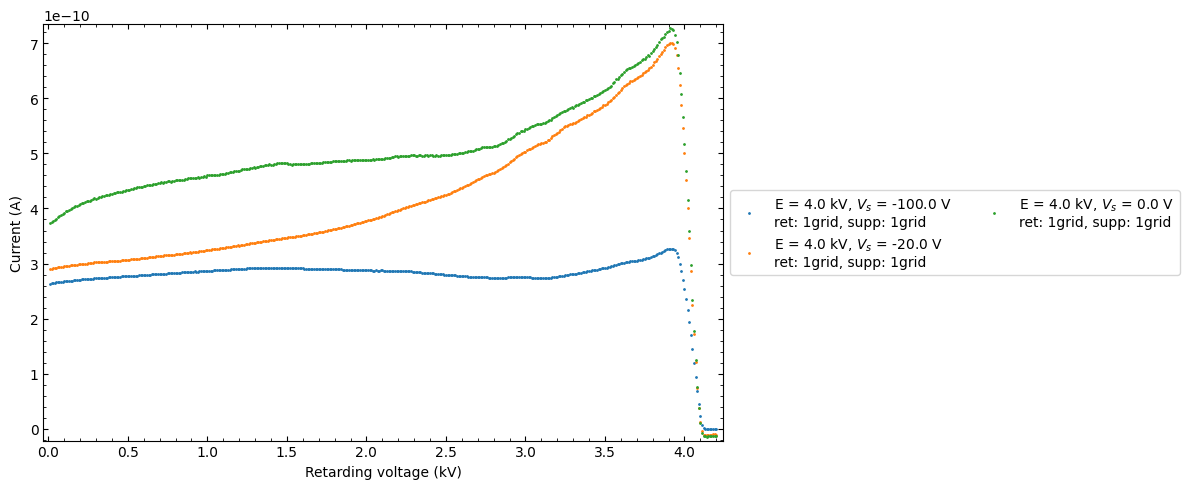

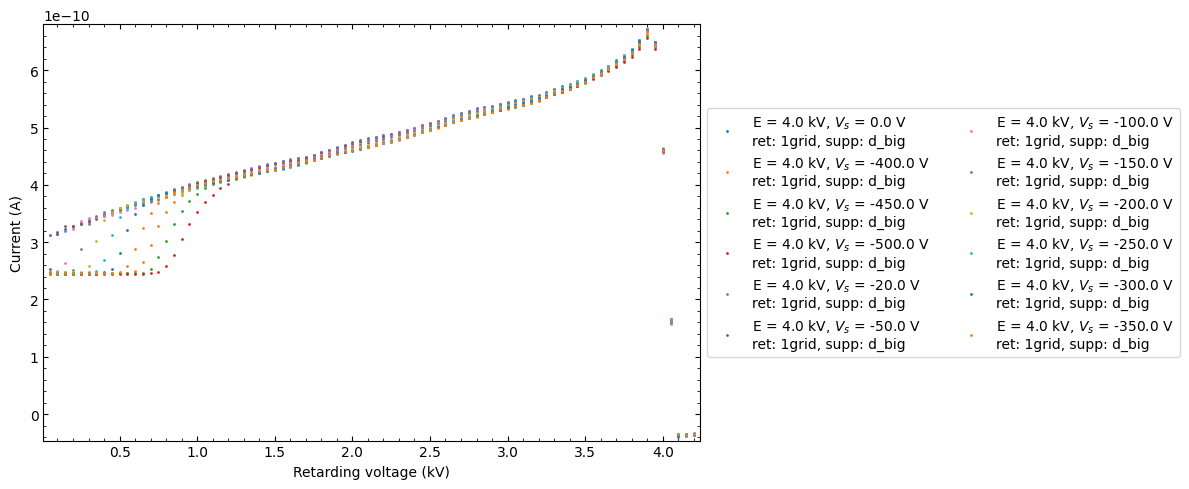

In [87]:
def filtered(day=None, energy=None, is_peak=None, supp_voltage=None, all_data=all_rfa_datas):
    """Filter the RFA data based on the given parameters. If one is None, it is not used for filtering.
        Energy in kV, supp_voltage in V."""
    return [data for data in all_data if all([
        day is None or data.measurement_day == day,
        energy is None or data.energy == energy,
        is_peak is None or data.is_peak == is_peak,
        supp_voltage is None or data.suppressor_voltage == supp_voltage
    ])]

for d in range(1, 5):
    basic_plot(filtered(energy=4, is_peak=False, day=d))

Last peak before drop-off: 3.924 kV, 2.545e-10 A


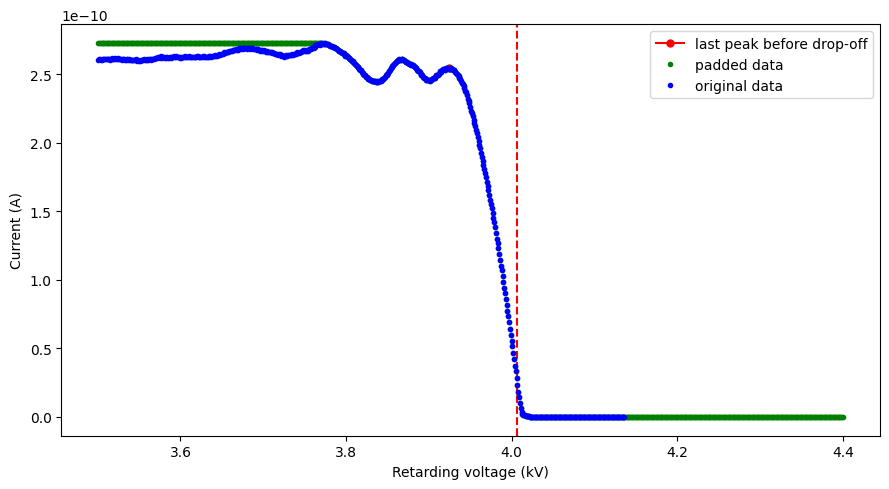

FWHM: 0.060 kV, FWHM as % of center: 1.51%


1.513369511304403

In [134]:
def gaussian_erf(x, a, b, c, d):
    """Gaussian error function where (a:amplitude, b:center, c:width, d:offset)"""
    return a * erf((x - b) / (c * np.sqrt(2))) + d

def fit_gaussian_erf(x_data, y_data):
    """Fits Gaussian error function to data. Returns (popt, pcov)"""
    p0 = [
        (max(y_data) - min(y_data))/2,  # amplitude 
        np.mean(x_data),                 # center
        (max(x_data) - min(x_data))/4,   # width
        np.mean(y_data)                  # offset
    ]
    
    return curve_fit(gaussian_erf, x_data, y_data, p0=p0)


import numpy as np
from scipy.signal import find_peaks

import numpy as np
from scipy.signal import find_peaks

import numpy as np
from scipy.signal import find_peaks

def find_last_peak_before_dropoff(x, y):
    """
    Find the last peak in the data before a significant drop-off.
    Handles very small magnitude data by using relative prominence.
    """
    
    # Calculate relative prominence based on data range
    y_range = np.max(y) - np.min(y)
    prominence = y_range * 0.01  # Use 1% of range as prominence threshold

    # Find peaks
    peaks, properties = find_peaks(y, prominence=prominence, distance=2)
    
    if len(peaks) == 0:
        print("No peaks found in data")
        return None, None
    
    # Calculate rolling average of differences to detect the big drop
    window_size = 5
    dy = np.diff(y)
    rolling_dy = np.convolve(dy, np.ones(window_size)/window_size, mode='valid')
    
    # Find where the rolling average shows a significant negative trend
    # Using a more sensitive threshold based on the standard deviation of differences
    drop_threshold = np.std(dy) * -3
    drop_points = np.where(rolling_dy < drop_threshold)[0]
    
    if len(drop_points) == 0:
        print("No significant drop-off found")
        return None, None
    
    # Find the last major drop point
    major_drop = drop_points[-1]
    
    # Find the last peak before the drop
    peaks_before_drop = peaks[peaks < major_drop]
    if len(peaks_before_drop) > 0:
        last_peak_idx = peaks_before_drop[-1]
        return x[last_peak_idx], y[last_peak_idx]
    
    return None, None


def fit_rfa_data(rfa, plot=False):
    """Fit Gaussian error function to the RFA data and plot the result."""
    max_current_index = np.argmax(rfa.current)

    # Create a padding so that the values before the max current just take the value of the max current
    x_data = rfa.retarding_voltage
    y_data = np.copy(rfa.current)
    y_data[:max_current_index] = y_data[max_current_index]
    
    # Add padding on the other side until 1.1 * rfa_data.energy
    padding_ret = np.arange(x_data[-1], 1.1 * rfa.energy, rfa.sweep_step)
    padding_current = np.full_like(padding_ret, y_data[-1])
    
    x_data = np.concatenate((x_data, padding_ret))
    y_data = np.concatenate((y_data, padding_current))

    x_peak, y_peak = find_last_peak_before_dropoff(rfa.retarding_voltage, rfa.current)
    
    fig, ax = plt.subplots(figsize=(9, 5), tight_layout=True)
    if x_peak is not None and y_peak is not None:
        ax.plot(x_peak, y_peak, label='last peak before drop-off', marker="o", markersize=5, color='r')
        ax.axvline(x=4.007, color='r', linestyle='--')
        print(f"Last peak before drop-off: {x_peak:.3f} kV, {y_peak:.3e} A")
    ax.plot(x_data, y_data, 'g.', label='padded data')
    ax.plot(rfa.retarding_voltage, rfa.current, 'b.', label='original data')
    ax.set_xlabel("Retarding voltage (kV)")
    ax.set_ylabel("Current (A)")
    ax.legend()
    plt.show()


    # Fit Gaussian error function
    popt_erf, _ = fit_gaussian_erf(x_data, y_data)
    
    # Derivative of Gaussian error function is a Gaussian
    a, b, c, _ = popt_erf
    popt_gaussian = [a / (c * np.sqrt(2 * np.pi)), b, c, 0]
    
    if plot:
        fig, ax = plt.subplots(figsize=(9, 5), tight_layout=True)
        ax.plot(rfa.retarding_voltage, rfa.current, 'b-', label='data')
        ax.plot(x_data, gaussian_erf(x_data, *popt_erf), 'r--', label='erf fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt_erf))
        
        ax.set_xlabel("Retarding voltage (kV)")
        ax.set_ylabel("Current (A)")
        ax.legend()
        plt.show()
        
        # Plot Gaussian fit
        fig, ax = plt.subplots(figsize=(9, 5), tight_layout=True)
        ax.plot(x_data, gaussian(x_data, *popt_gaussian), 'r--')
        
        ax.set_xlabel("Retarding voltage (kV)")
        ax.set_ylabel("Current derivative (A/kV)")
        ax.legend()
        plt.show()
    
    # Calculate FWHM (Full Width at Half Maximum)
    a, b, c, d = popt_gaussian
    fwhm = 2 * np.sqrt(2 * np.log(2)) * c
    fwhm_percent = (fwhm / b) * 100
    print(f"FWHM: {fwhm:.3f} kV, FWHM as % of center: {fwhm_percent:.2f}%")
    return fwhm_percent

# Example usage:
fit_rfa_data(filtered(energy=4, is_peak=True, day=1)[0])

# TODO
- resolution
- OPTION to normalize all by starting point (mostly for plot ig)
- filter: list of options but in
- errors in the resolution
- ask luk for current errors?